# Waveguide to ring coupling

Optical ring resonators are key components in the field of integrated photonics. The unique capability of ring resonators to selectively interact with specific wavelengths of light makes them extremely versatile. They can be utilized in a broad array of applications, including optical filtering, modulating, switching, and sensing. However, simulating a ring resonator can be computationally expensive due to the high-Q resonances. Alternatively, we can investigate the coupling between a straight waveguide to a ring only by simulating the coupling region. The coupling coefficients can be extracted from this much simpler simulation. 

Noticeably, in a waveguide-to-ring simulation, one of the simulation domain boundaries intersects the ring structure. Non-translational invariant structures inside PML are known to cause instabilities in a FDTD simulation so such a simulation is likely to **diverge**. In this notebook, we will try to use the PML boundary first to see if the simulation diverges. When it does, we will apply an effective remedy under this situation: **replacing the PML with the adiabatic absorber boundary**. The absorber functions similarly to PML such that it absorbs the outgoing radiation to mimic the infinite space. However, the absorber has a slightly higher reflection and requires a bit more computation than PML but it is numerically much more stable.

<img src="img/waveguide_to_ring.png" width="500">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gdstk

import tidy3d as td
import tidy3d.web as web

## Simulation Setup 

Define simulation wavelength range to be 1.5 $\mu m$ to 1.6 $\mu m$.
.

In [2]:
lda0 = 1.55  # central wavelength
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range of interest
freq0 = td.C_0 / lda0  # central frequency
freqs = td.C_0 / ldas  # frequency range of interest
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # frequency width of the source

The ring and waveguide are made of silicon. The top and bottom claddings are made of silicon oxide. Here we use the materials from Tidy3D's [material library](../material_library.html) directly.

In [3]:
# define silicon and silicon dioxide media from the material library
si = td.material_library["cSi"]["Li1993_293K"]
sio2 = td.material_library["SiO2"]["Horiba"]

Define the geometric parameters. The waveguide is 500 nm wide and 220 nm thick. The ring has a radius of 5 $\mu m$ and the gap size is 50 nm.

In [4]:
w = 0.5  # width of the waveguide
h_si = 0.22  # thickness of the silicon layer
gap = 0.05  # gap size between the waveguides and the ring
r = 5  # radius of the ring
inf_eff = 1e2  # effective infinity

# simulation domain size
Lx = 2 * r + 2 * lda0
Ly = r / 2 + gap + 2 * w + lda0
Lz = 9 * h_si

We only need to define two structures: a straight waveguide and a ring. Both are commonly used PIC components introduced in the [demonstration notebook](../notebooks/PICComponents.html). We can simply copy the associated functions here and them use to define the structures quickly. Namely, we copy the `straight_waveguide` function and the `ring_resonator` function.

In [5]:
def straight_waveguide(x0, y0, z0, x1, y1, wg_width, wg_thickness, medium, sidewall_angle=0):
    """
    This function defines a straight strip waveguide and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of the waveguide starting position (um)
    y0: y coordinate of the waveguide starting position (um)
    z0: z coordinate of the waveguide starting position (um)
    x1: x coordinate of the waveguide end position (um)
    y1: y coordinate of the waveguide end position (um)
    wg_width: width of the waveguide (um)
    wg_thickness: thickness of the waveguide (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """

    cell = gdstk.Cell("waveguide")  # define a gds cell

    path = gdstk.RobustPath((x0, y0), wg_width, layer=1, datatype=0)  # define a path
    path.segment((x1, y1))

    cell.add(path)  # add path to the cell

    # define geometry from the gds cell
    wg_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
    )

    # define tidy3d structure of the bend
    wg = td.Structure(geometry=wg_geo[0], medium=medium)

    return wg

In [6]:
def ring_resonator(
    x0,
    y0,
    z0,
    R,
    wg_width,
    wg_thickness,
    medium,
    sidewall_angle=0,
):
    """
    This function defines a ring and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of center of the ring (um)
    y0: y coordinate of center of the ring (um)
    z0: z coordinate of center of the ring (um)
    R: radius of the ring (um)
    wg_width: width of the waveguide (um)
    wg_thickness: thickness of the waveguide (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """

    cell = gdstk.Cell("top")  # define a gds cell

    # define a path
    path_top = gdstk.RobustPath(
        (x0 + R, y0), wg_width - wg_thickness * np.tan(np.abs(sidewall_angle)), layer=1, datatype=0
    )
    path_top.arc(R, 0, np.pi)  # make the top half of the ring
    cell.add(path_top)  # add path to the cell

    # the reference plane depends on the sign of the sidewall_angle
    if sidewall_angle >= 0:
        reference_plane = "top"
    else:
        reference_plane = "bottom"

    # define top half ring geometry
    ring_top_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
        reference_plane=reference_plane,
    )

    # similarly for the bottom half of the ring
    cell = gdstk.Cell("bottom")
    path_bottom = gdstk.RobustPath(
        (x0 + R, y0), wg_width - wg_thickness * np.tan(np.abs(sidewall_angle)), layer=1, datatype=0
    )

    path_bottom.arc(R, 0, -np.pi)
    cell.add(path_bottom)

    ring_bottom_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
        reference_plane=reference_plane,
    )

    # define ring structure
    ring = td.Structure(
        geometry=td.GeometryGroup(geometries=ring_bottom_geo + ring_top_geo), medium=medium
    )

    return ring

Use the above functions to define the [Structures](../_autosummary/tidy3d.Structure.html).

In [7]:
# define straight waveguide
waveguide = straight_waveguide(
    x0=-inf_eff,
    y0=0,
    z0=0,
    x1=inf_eff,
    y1=0,
    wg_width=w,
    wg_thickness=h_si,
    medium=si,
    sidewall_angle=0,
)

# define ring
ring = ring_resonator(
    x0=0,
    y0=w + gap + r,
    z0=0,
    R=r,
    wg_width=w,
    wg_thickness=h_si,
    medium=si,
    sidewall_angle=0,
)

We will use a [ModeSource](../_autosummary/tidy3d.ModeSource.html) to excite the straight waveguide using the fundamental TE mode. A [ModeMonitor](../_autosummary/tidy3d.ModeMonitor.html) is placed at the through to measure the transmission. Another [ModeMonitor](../_autosummary/tidy3d.ModeMonitor.html) is placed at the ring to measure the coupling to the ring. For the monitor at the ring, we need to properly set up `angle_theta`, `angle_theta`, and `bend_axis` in the [ModeSpec](../_autosummary/tidy3d.ModeSpec.html). Finally, we add a [FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) to help visualize the field distribution.

In [8]:
n_si = 3.47
# mode spec for the source
mode_spec_source = td.ModeSpec(num_modes=1, target_neff=n_si)
# mode spec for the through port
mode_spec_through = mode_spec_source
# angle of the mode at the ring
theta = np.pi / 4
# mode spec for the drop port at the ring
mode_spec_drop = td.ModeSpec(
    num_modes=1, target_neff=n_si, angle_theta=theta, bend_radius=-r, bend_axis=1
)

# add a mode source as excitation
mode_source = td.ModeSource(
    center=(-r - lda0 / 4, 0, 0),
    size=(0, 6 * w, 6 * h_si),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec_source,
    mode_index=0,
)

# add a mode monitor to measure transmission at the through port
mode_monitor_through = td.ModeMonitor(
    center=(r + lda0 / 4, 0, 0),
    size=mode_source.size,
    freqs=freqs,
    mode_spec=mode_spec_through,
    name="through",
)

# add a mode monitor to measure transmission at the drop port
mode_monitor_drop = td.ModeMonitor(
    center=(np.sin(theta) * r, w + gap + r - np.cos(theta) * r, 0),
    size=(6 * w, 0, 6 * h_si),
    freqs=freqs,
    mode_spec=mode_spec_drop,
    name="drop",
)

# add a field monitor to visualize the field distribution
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

## Using PML Boundary 

Finally, we define the Simulation. Intuitively, we would use the [PML](../_autosummary/tidy3d.PML.html) boundary on all sides similar to what we did in most other PIC component simulations. Let's try it here.

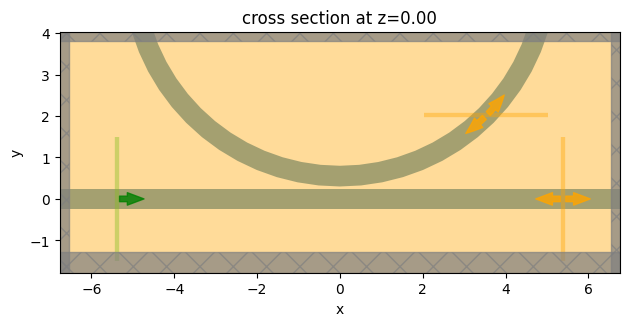

In [9]:
run_time = 2e-12  # simulation run time

# construct simulation
sim_pml = td.Simulation(
    center=(0, Ly / 4, 0),
    size=(Lx, Ly, Lz),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=25, wavelength=lda0),
    structures=[waveguide, ring],
    sources=[mode_source],
    monitors=[mode_monitor_through, mode_monitor_drop, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
    symmetry=(0, 0, 1),
)

# plot simulation
sim_pml.plot(z=0)
plt.show()

Submit the simulation to the server to run. 

In [10]:
sim_data = web.run(
    simulation=sim_pml, task_name="waveguide_to_ring", path="data/simulation_data.hdf5"
)

[09:14:41] Created task 'waveguide_to_ring' with task_id                                              ]8;id=782040;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=869684;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#186\186]8;;\
           'fdve-ae1e3759-25ae-4d3a-b991-e5b743eccef9v1'.                                                          

           View task using web UI at                                                                  ]8;id=968529;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=609377;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=712277;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae1e3759-25ae-4d3a-b991-e5b743eccef9v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=469051;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae1e3759-25ae-4d3a-b991-e5b743eccef9v1\taskId]8;;\]8;id=712277;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae1e3759-25ae-4d3a-b991-e5b743eccef9v1\=]8;;\]8;id=946583;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae1e3759-25ae-4d3a-b991-e5b743eccef9v1\fdve]8;;\]8;id=712277;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae1e3759-25ae-4d3a-b991-e5b743eccef9v1\-ae1e3759-25ae-4d3a-b991-e5b743eccef]8;;\              
           ]8;id=712277;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae1e3759-25ae-4d3a-b991-e5b743eccef9v1\9v1']8;;\.                                                                                                   

Output()

[09:14:43] status = queued                                                                            ]8;id=698389;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=20849;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#321\321]8;;\

Output()

[09:14:46] status = preprocess                                                                        ]8;id=107313;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=402035;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#315\315]8;;\

[09:14:53] Maximum FlexCredit cost: 0.210. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=746919;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=472214;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=4292;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=61664;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=827242;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=88560;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#352\352]8;;\

Output()

[09:16:51] early shutoff detected, exiting.                                                           ]8;id=670739;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=688639;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=178804;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=735197;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#383\383]8;;\

Output()

[09:17:00] status = diverged                                                                          ]8;id=904600;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=846161;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\

Output()

[09:17:02] loading SimulationData from data/simulation_data.hdf5                                      ]8;id=369562;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=279055;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#568\568]8;;\

[09:17:02] WARNING: Simulation final field decay value of 1.0 is greater than the simulation shutoff  ]8;id=916782;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=473052;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#575\575]8;;\
           threshold of 1e-05. Consider simulation again with large run_time duration for more                     
           accurate results.                                                                                       

Now we see that the status of the job is shown to be **diverged**. As discussed in the introduction, it should not come as a surprise since the ring section in the PML layer is not perpendicular to the boundary and translational invariant as shown in the zoomed-in plot below.

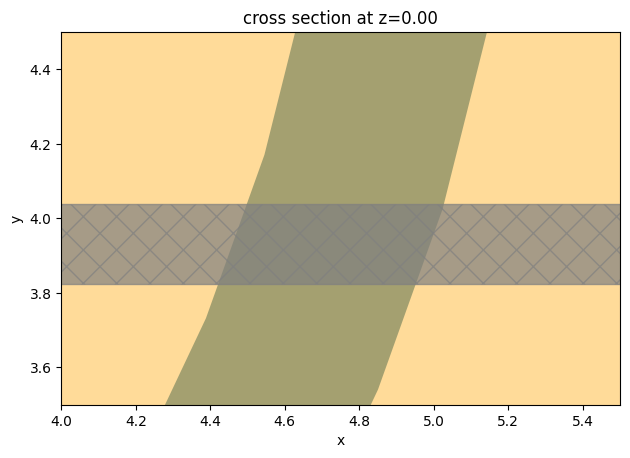

In [11]:
# zoom-in plot around the pml
ax = sim_pml.plot(z=0)
ax.set_xlim(4, 5.5)
ax.set_ylim(3.5, 4.5)
plt.show()

This can be further confirmed by plotting the electric field distribution. From the plot, we can see where the field built up and caused the simulation to diverge. As expected, the field built up around the ring to PML area. 

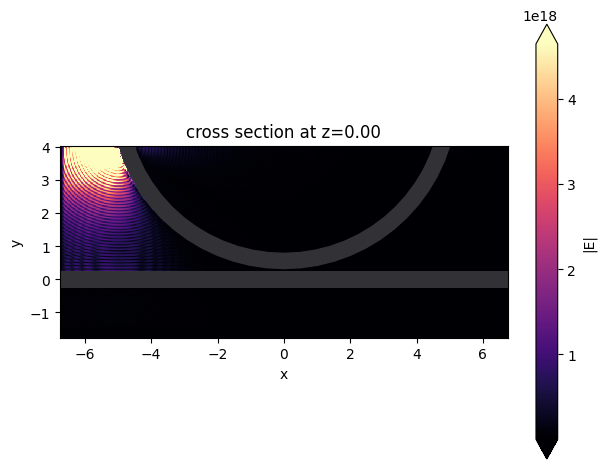

In [12]:
sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs")
plt.show()

## Using Absorber Boundary 

To resolve the diverge, we can switch to [Absorber](../_autosummary/tidy3d.Absorber.html). This can be done by copying the previous simulation and only updating the `boundary_spec`. Since the ring is only intersecting the boundary in the y direction, we only need to apply [Absorber](../_autosummary/tidy3d.Absorber.html) to the positive $y$ boundary. 

In [13]:
# copy simulation and update boundary condition
sim_absorber = sim_pml.copy(
    update={
        "boundary_spec": td.BoundarySpec(
            x=td.Boundary.pml(),
            y=td.Boundary(plus=td.Absorber(), minus=td.PML()),
            z=td.Boundary.pml(),
        )
    }
)

# run simulation
sim_data = web.run(
    simulation=sim_absorber, task_name="waveguide_to_ring", path="data/simulation_data.hdf5"
)

[09:17:03] Created task 'waveguide_to_ring' with task_id                                              ]8;id=675783;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=535032;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#186\186]8;;\
           'fdve-fed861a9-a951-48ff-8968-03d4e2a9fee5v1'.                                                          

           View task using web UI at                                                                  ]8;id=366847;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=843813;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=167535;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fed861a9-a951-48ff-8968-03d4e2a9fee5v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=524018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fed861a9-a951-48ff-8968-03d4e2a9fee5v1\taskId]8;;\]8;id=167535;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fed861a9-a951-48ff-8968-03d4e2a9fee5v1\=]8;;\]8;id=119991;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fed861a9-a951-48ff-8968-03d4e2a9fee5v1\fdve]8;;\]8;id=167535;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fed861a9-a951-48ff-8968-03d4e2a9fee5v1\-fed861a9-a951-48ff-8968-03d4e2a9fee]8;;\              
           ]8;id=167535;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fed861a9-a951-48ff-8968-03d4e2a9fee5v1\5v1']8;;\.                                                                                                   

Output()

[09:17:05] status = queued                                                                            ]8;id=11485;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=988492;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#321\321]8;;\

Output()

[09:17:22] status = preprocess                                                                        ]8;id=578408;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=564297;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#315\315]8;;\

[09:17:27] Maximum FlexCredit cost: 0.231. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=309905;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=789302;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=476434;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=108390;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=251107;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=806825;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#352\352]8;;\

Output()

[09:18:29] early shutoff detected, exiting.                                                           ]8;id=328237;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=369055;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=12760;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=616377;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#383\383]8;;\

Output()

[09:18:52] status = success                                                                           ]8;id=957878;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=595993;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\

Output()

[09:18:55] loading SimulationData from data/simulation_data.hdf5                                      ]8;id=890445;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=233645;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#568\568]8;;\

After switching to [Absorber](../_autosummary/tidy3d.Absorber.html), the simulation doesn't run into the divergence issue anymore and thus we can plot the transmission spectra to the through and drop ports.

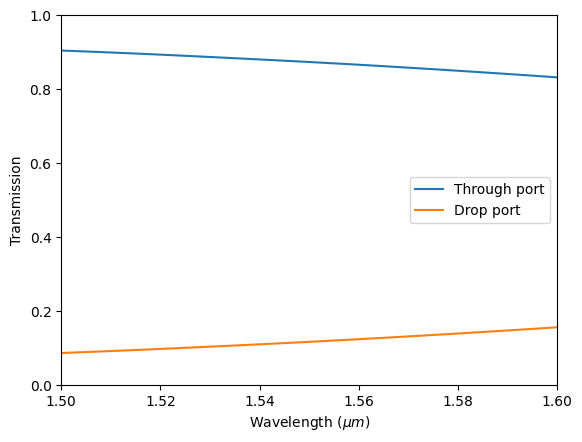

In [14]:
# extract mode amplitude in the through port
t = sim_data["through"].amps.sel(mode_index=0, direction="+")
# extract mode amplitude in the drop port
k = sim_data["drop"].amps.sel(mode_index=0, direction="+")

# plot transmission
plt.plot(ldas, np.abs(t) ** 2, label="Through port")
plt.plot(ldas, np.abs(k) ** 2, label="Drop port")
plt.legend()
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Transmission")
plt.xlim(1.5, 1.6)
plt.ylim(0, 1)
plt.show()

Again we can visualize the field distribution. This time, we see the correct result where the energy is partially coupled to the ring and partially stays in the straight waveguide.

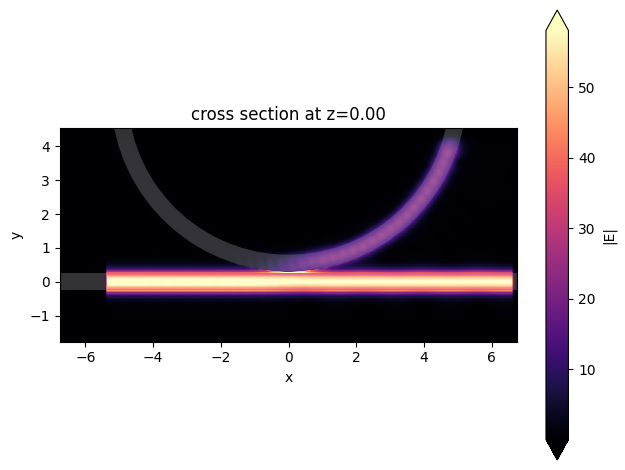

In [15]:
sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs")
plt.show()

## Additional Notes on Absorber

The adiabatic absorber is a multilayer system with gradually increasing conductivity. As briefly discussed above, the absorber usually has a larger undesired reflection compared to PML. In practice, this small difference rarely matters, but is important to understand for simulations that require high accuracy. There are two possible sources for the reflection from absorbers. The first, and more common one, is that the ramping up of the conductivity is not sufficiently slow, which can be remedied by increasing the number of absorber layers (40 by default). The second one is that the absorption is not high enough, such that the light reaches the PEC boundary at the end of the Absorber, travels back through it, and is still not fully attenuated before re-entering the simulation region. If this is the case, increasing the maximum conductivity (see the [API reference](../_autosummary/tidy3d.Absorber.html)) can help. In both cases, changing the order of the scaling of the conductivity (`sigma_order`) can also have an effect, but this is a more advanced setting that we typically do not recommend modifying.